# Modeling

The objective of this notebook is to try different approaches to 'model' our data in the sense of obtaining statistically significant information to be able to recommend products to users.

In [1]:
from matplotlib import pyplot
from processing import *
from tools import *
from modeling import *
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from os import path

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
df_order_products_train = pd.read_csv('data/instacart_2017_05_01/order_products__train.csv')
df_order_products_prior = pd.read_csv('data/instacart_2017_05_01/order_products__prior.csv')
df_products = pd.read_csv('data/instacart_2017_05_01/products.csv')

In [5]:
df_orders = pd.read_csv('data/enhanced/df_orders.csv')
# Filter orders right away so code bellow is less verbose
df_orders_prior = df_orders.loc[df_orders['eval_set'] == 'prior']
df_orders_train = df_orders.loc[df_orders['eval_set'] == 'train']
df_orders_test = df_orders.loc[df_orders['eval_set'] == 'test']

/Users/lgarcia/opt/anaconda3/envs/ds-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# all the user ides are unique in df_orders_train 
assert df_orders_train.shape[0] == df_orders_train['user_id'].nunique()
df_orders_train.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_date,week_of_year,product_sequences
0,2236879,30088,train,4,3,0,29.0,2016-04-01 00:00:00,13,bunchedcilantro_28842 redvinetomato_34969 cola...
1,857644,69792,train,4,0,0,29.0,2016-04-01 00:00:00,13,organicavocado_47766 shreddedparmesan_4799 unc...
2,2379808,193128,train,4,6,0,0.0,2016-04-01 00:00:00,13,9paperplate_19779 classicmixvariety_19734
3,274779,35031,train,4,2,0,0.0,2016-04-01 00:00:00,13,schoolsafechocolatecupcakes_28489 organicwhole...
4,91799,62272,train,4,1,1,0.0,2016-04-01 01:00:00,13,organicwholewheatelbows_283 ripelargepittedoli...


In [7]:
tmp_group = df_order_products_train.merge(df_orders_train, how='left', on='order_id').groupby(['user_id']).get_group(202279).merge(df_products, how='left', on='product_id')
tmp_group.head(50)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_date,week_of_year,product_sequences,product_name,aisle_id,department_id
0,1050357,33120,1,1,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Organic Egg Whites,86,16
1,1050357,1003,2,1,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Organic Turkey Bone Broth,5,13
2,1050357,21543,3,1,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Organic Quick Oats,130,14
3,1050357,20995,4,1,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Organic Broccoli Florets,116,1
4,1050357,46064,5,0,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Lightly Salted Brown Rice Cakes,78,19
5,1050357,20168,6,0,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Organic Sunflower Seed Spread,88,13
6,1050357,42824,7,1,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Black Eyed Peas,116,1
7,1050357,4461,8,1,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Organic Raw Unfiltered Apple Cider Vinegar,19,13
8,1050357,45002,9,1,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Organic Balsamic Vinegar Of Modena,19,13
9,1050357,8693,10,0,202279,train,9,1,14,30.0,2016-09-02 14:00:00,35,organiceggwhites_33120 organicturkeybonebroth_...,Dairy Free French Vanilla Creamer Almond Milk,100,21


In [8]:
df_orders_prior = df_orders_prior.set_index('order_date')
df_orders_prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,week_of_year,product_sequences
order_date,,,,,,,,,
2016-01-01 00:00:00,2806644,178467,prior,1,2,0,0.0,53,organicbabyspinach_21903 seedlessredgrapes_492...
2016-01-01 00:00:00,22120,36713,prior,1,0,0,0.0,53,basilpesto_12206 supremelyspicyhummus_15923 or...
2016-01-01 00:00:00,2455270,36705,prior,1,0,0,0.0,53,organicgreencabbage_47734 unsweetenedalmondmil...
2016-01-01 00:00:00,1995532,167516,prior,1,0,0,0.0,53,cornchips_11576 organicstrawberries_21137 orga...
2016-01-01 00:00:00,46045,29128,prior,1,1,0,0.0,53,hassavocados_12341


In [9]:
df_month = df_orders_prior.loc[(df_orders_prior.index >= '2016-11') & (df_orders_prior.index <= '2016-12')]
df_month.shape
df_month.head()

(1638963, 9)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,week_of_year,product_sequences
order_date,,,,,,,,,
2016-11-01 00:00:00,1127769,89779,prior,24,0,0,0.0,44,organicbabyspinach_21903 squeezedorangejuice_4...
2016-11-01 00:00:00,2405636,157190,prior,23,5,0,30.0,44,organicjalapenopepper_35939 organicpineappleco...
2016-11-01 00:00:00,2498937,48510,prior,22,5,0,30.0,44,marinara_24170 minicucumbers_1408 spinach_4820...
2016-11-01 00:00:00,677471,136362,prior,22,5,0,30.0,44,organicunsweetenedvanillaalmondmilk_14084 froz...
2016-11-01 00:00:00,2479647,169066,prior,15,5,0,30.0,44,banana_24852 goldendeliciousapple_23322 malbec...


In [10]:
# all_sequences = extract_orders_from_slice(df_month, df_products, df_order_products_prior, as_sentences=True)
# all_sequences[:5]

## Processing

In this section we will process our data so that we can extract the product sequences that correspond t each one of the users. We will also extract all the product sequences and put them together so we can later embed them into a vector space.

In [11]:
def encode_product_name(product_name, product_id):
    # Lowercase, remove special characters.
    encoded_name = ''.join(e for e in product_name if e.isalnum()).lower() + '_{}'.format(str(product_id))
    return encoded_name

print(encode_product_name('85% Lean Ground Beef', 1))

85leangroundbeef_1


In [12]:
if path.exists('data/enhanced/df_products.csv') == False:
    # Compute product encoding
    df_products['product_name_encoded'] = df_products.apply(lambda row: encode_product_name(row['product_name'], row['product_id']) , axis=1)
    # Save it to disk
    df_products.to_csv('data/enhanced/df_products.csv', index = None, header=True)
else:
    # Otherwise load the data
    df_products = pd.read_csv('data/enhanced/df_products.csv')
    
df_products.head()

,product_id,product_name,aisle_id,department_id,orders_per_product_train,orders_per_product_prior,product_name_encoded
0,1,Chocolate Sandwich Cookies,61,19,76.0,1852.0,chocolatesandwichcookies_1
1,2,All-Seasons Salt,104,13,4.0,90.0,allseasonssalt_2
2,3,Robust Golden Unsweetened Oolong Tea,94,7,6.0,277.0,robustgoldenunsweetenedoolongtea_3
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22.0,329.0,smartonesclassicfavoritesminirigatoniwithvodka...
4,5,Green Chile Anytime Sauce,5,13,1.0,15.0,greenchileanytimesauce_5


In [13]:
assert df_products['product_name'].nunique() == df_products['product_name_encoded'].nunique()
print(df_products['product_name'].nunique() )
print(df_products['product_name_encoded'].nunique())

49688
49688


### Extract sequences for each user

Here we will create a dictionary with user id as key and and product sequences per user as values. So we can have refer to the sequences that correspond to each one of the users. The data has been pre-extracted so now we will only need to load it from dist to work with it. The extraction methods can be found in the file : processing.py

In [14]:
# Load train product sequences as python lists into user dictionary and list of lists  
list_sequences_train = load_file('sequences/train/list_sequences_train.pkl')
list_sequences_user_dict_train = load_file('sequences/train/list_sequences_user_dict_train.pkl')

# Load train product sequences as sentences
sentences_all_train = load_file('sequences/train/sentences_all_train.pkl')
sentences_user_dict_train = load_file('sequences/train/sentences_user_dict_train.pkl')

In [15]:
list_sequences_train[:1]
sentences_all_train[:1]
print('--------------------------')
list_sequences_user_dict_train[10]
sentences_user_dict_train[10]

[['Soda',
  'Organic String Cheese',
  '0% Greek Strained Yogurt',
  'XL Pick-A-Size Paper Towel Rolls',
  'Milk Chocolate Almonds',
  'Pistachios',
  'Cinnamon Toast Crunch',
  'Aged White Cheddar Popcorn',
  'Organic Whole Milk',
  'Organic Half & Half',
  'Zero Calorie Cola']]

['soda_196 organicstringcheese_25133 0greekstrainedyogurt_38928 xlpickasizepapertowelrolls_26405 milkchocolatealmonds_39657 pistachios_10258 cinnamontoastcrunch_13032 agedwhitecheddarpopcorn_26088 organicwholemilk_27845 organichalfhalf_49235 zerocaloriecola_46149']

--------------------------


[array(['Pork Chorizo', 'Shoestring Fries', 'Potato Hot Dog Buns',
        'German Barrel Sauerkraut'], dtype=object)]

'porkchorizo_29650 shoestringfries_48720 potatohotdogbuns_24654 germanbarrelsauerkraut_10177'

Let's grab a sample user and see how the data was processed for it.

In [16]:
sample_user = 7
sequence_dict =  list_sequences_user_dict_train
sentences_dict = sentences_user_dict_train

print('First 10 users : {}'.format(list(sentences_dict.keys())[:10]))
print('Exploring processed data for sample user: {} \n'.format(str(sample_user)))
print('Sentences for sample user: \n {} \n'.format(sentences_dict[sample_user]))
print('Sequences for sample user: \n {} \n'.format(sequence_dict[sample_user]))
print('First 10 user ids: {}'.format(list(sentences_dict.keys())[:10]))

# Verify that the sentences and the list sequences are equivalent:
# for i, product in enumerate(sentences_dict[sample_user].split()):
#     assert product == sequence_dict[sample_user][i], 'Products are not identical in sentences and in seq of products'

# Lets have a look at the first orders for the sample user.
order_id = df_orders_train.loc[df_orders_train['user_id']==sample_user]['order_id'].values[0]
df_order_products_train.loc[df_order_products_train['order_id']==order_id].merge(df_products, how='left', on='product_id')


First 10 users : [1, 2, 5, 7, 8, 9, 10, 13, 14, 17]
Exploring processed data for sample user: 7 

Sentences for sample user: 
 panamapeachantioxidantinfusion_12053 antioxidantinfusionsbeveragemalawimango_47272 antioxidantinfusionsipanemapomegranatebeverage_37999 85leangroundbeef_13198 raspberrylemonade_43967 lactosefreefatfreemilk_40852 vanillacoffeeconcentrate_17638 organicdarkbrownsugar_29894 honeycrispapple_45066 

Sequences for sample user: 
 [array(['Panama Peach Antioxidant Infusion',
       'Antioxidant Infusions Beverage Malawi Mango',
       'Antioxidant Infusions Ipanema Pomegranate Beverage',
       '85% Lean Ground Beef', 'Raspberry Lemonade',
       'Lactose Free Fat Free Milk', 'Vanilla Coffee Concentrate',
       'Organic Dark Brown Sugar', 'Honeycrisp Apple'], dtype=object)] 

First 10 user ids: [1, 2, 5, 7, 8, 9, 10, 13, 14, 17]


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,orders_per_product_train,orders_per_product_prior,product_name_encoded
0,525192,12053,1,0,Panama Peach Antioxidant Infusion,31,7,27.0,610.0,panamapeachantioxidantinfusion_12053
1,525192,47272,2,1,Antioxidant Infusions Beverage Malawi Mango,31,7,27.0,644.0,antioxidantinfusionsbeveragemalawimango_47272
2,525192,37999,3,1,Antioxidant Infusions Ipanema Pomegranate Beve...,31,7,33.0,765.0,antioxidantinfusionsipanemapomegranatebeverage...
3,525192,13198,4,1,85% Lean Ground Beef,122,12,642.0,12123.0,85leangroundbeef_13198
4,525192,43967,5,1,Raspberry Lemonade,31,7,236.0,5315.0,raspberrylemonade_43967
5,525192,40852,6,1,Lactose Free Fat Free Milk,91,16,167.0,4650.0,lactosefreefatfreemilk_40852
6,525192,17638,7,1,Vanilla Coffee Concentrate,26,7,85.0,1975.0,vanillacoffeeconcentrate_17638
7,525192,29894,8,1,Organic Dark Brown Sugar,17,13,55.0,1501.0,organicdarkbrownsugar_29894
8,525192,45066,9,1,Honeycrisp Apple,24,4,3551.0,79769.0,honeycrispapple_45066


## Colaborative filtering

In this section we will explore if we can recommend products based on the co-occurrence in the same context (order basket) with other products. 



### Co-occurrence of products in the same context
We will make use of sklearn's CountVectorizer in order to create the co-occurrence matrix of all our product sequences. Then we will use it to explore which products are more likely to be bought alongside other products. This will be the base mechanism of our simple recommender system.

In [17]:
sequence_dict =  list_sequences_user_dict_train
sequence_list = list_sequences_train
sentences_dict = sentences_user_dict_train
sentence_lists = sentences_all_train

In [18]:
# Method in modeling.py
count_model, X = count_vectorizer(sentence_lists)

In [19]:
def matrix_breakdown(matrix_array):
    print('Number of rows in matrix: {}'.format(len(matrix_array)))
    print('Number of columns (elements in each row): {} \n'.format(len(matrix_array[0])))

    # Print the first three 
    print('First few rows of matrix')
    for i in range(0,3): # len(matrix_array)):
        print(matrix_array[i])

    print('-------------------------------------------')
    
    flat_sequence_list = [product for sequence in sequence_list for product in sequence]
    unique_products = list(set(flat_sequence_list))
    
    # Verify that row length must equal size of vocabulary
    assert len(matrix_array[0]) == len(count_model.vocabulary_.keys()), 'Row length must equal size of vocabulary'
    # Veryfy that the uique products found in the sequences used to create the matrix are actually equal to the vocabulary learned by Countvectorizer
#     assert len(count_model.vocabulary_.keys()) == len(unique_products), 'Unique products must be equal to bocabulary learned'

    print('Unique products in sequences: {}'.format(len(unique_products)))
    print('Length of vocabulary : {} \n'.format(len(count_model.vocabulary_.keys())))
    print('Vocabulary (first 50): \n {} \n'.format(list(count_model.vocabulary_)[:50]))
#     print('Feature names : {}'.format(count_model.get_feature_names()))

In [20]:
matrix_breakdown(X.toarray())
print(count_model.stop_words_)

Number of rows in matrix: 131209
Number of columns (elements in each row): 39123 

First few rows of matrix
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
-------------------------------------------
Unique products in sequences: 39123
Length of vocabulary : 39123 

Vocabulary (first 50): 
 ['soda_196', 'organicstringcheese_25133', '0greekstrainedyogurt_38928', 'xlpickasizepapertowelrolls_26405', 'milkchocolatealmonds_39657', 'pistachios_10258', 'cinnamontoastcrunch_13032', 'agedwhitecheddarpopcorn_26088', 'organicwholemilk_27845', 'organichalfhalf_49235', 'zerocaloriecola_46149', 'organicroastedturkeybreast_22963', 'glutenfreewholegrainbread_7963', 'plantainchips_16589', 'chipotlebeefporkrealstick_32792', 'bartlettpears_41787', 'organicdanjoupears_22825', 'asianpears_13640', 'banana_24852', 'honeycrispapple_45066', 'grannysmithapples_9387', 'smallhassavocado_5450', 'unsweetenedalmondmilk_24838', 'bubblegumflavornaturalchewinggum_38547', 'uncuredslowcookedham_19019', 'organicalld

No product is considered as a stop words. This means that products with very high number of sales might bias our results. 

In [21]:
def vectors_for_products_in_freq_matrix(vectorizer, matrix, product_names, verbose=True):
    """
    Return rows of frequencey matrix that correspond to products passed.
    - param vectorizer: count_vectorizer model 
    - param matrix: Product frequency matrix (returned by count vectorizer)
    - param product_names: Names of the products for which we want to obtain the frequency rows
    - param verbose: Defaults to true. Whether or not to print the logs
    - return binary_rep_list: Return rows of frequencey matrix that correspond to products passed.
    """
    # Returns a list of vectors asociated to each one of the products
    binary_rep_list = []
    for product_name in product_names:
        feature_index = vectorizer.vocabulary_[product_name]
        sequence_counts = [binary[0] for binary in matrix[:, feature_index:feature_index + 1]]
        binary_rep_list.append(sequence_counts)

        if verbose == True:
            print('Product encoded name: {}, \nFeature index: {}'.format(product_name, feature_index))
            print('Item frequency in product sequence: {}'.format(sequence_counts[:50]))

    return binary_rep_list

In [22]:
sample_products = ['0greekstrainedyogurt_38928', '100pureeucalyptusessentialoil_20843']
count_vectors = vectors_for_products_in_freq_matrix(count_model, X.toarray(), sample_products, verbose=True)

Product encoded name: 0greekstrainedyogurt_38928, 
Feature index: 14
Item frequency in product sequence: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Product encoded name: 100pureeucalyptusessentialoil_20843, 
Feature index: 258
Item frequency in product sequence: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
print(list(count_vectors[0])[:50])
# print(count_vectors)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Observations
- Above we can see the frequency vectors that correspond to each one of the products in each sequence
- 0greekstrainedyogurt_38928 has been seen once in the first sequence only
- 100pureeucalyptusessentialoil_20843 has been seen in the third sequence only

### Co-occurrence matrix

Let's now use the sequence frequency matrix that we computed above in order to calculate the Item co-occurrence matrix. This new matrix will have dimension 125x125 since it will represent a mapping of which items have been seen together in the same context

In [24]:
def vectors_for_products_in_cooccurrence_matrix(vectorizer, matrix, product_names, verbose=True):
    """
    Return rows of co-occurrence matrix that correspond to products passed.
    - param vectorizer: count_vectorizer model 
    - param matrix: Co-ocurrence matrix 
    - param product_names: Names of the products for which we want to obtain the frequency rows
    - param verbose: Defaults to true. Whether or not to print the logs
    - return binary_rep_list: Return rows of frequencey matrix that correspond to products passed.
    """
    # Returns a dictionary
    binary_rep_list = {}
    for product_name in product_names:
        feature_index = vectorizer.vocabulary_[product_name]
        sequence_counts = matrix[feature_index]
        binary_rep_list[product_name] = sequence_counts

        if verbose == True:
            print('Product encoded name: {}, \nFeature index: {}'.format(product_name, feature_index))
            print('Item frequencey in product sequence: {}'.format(sequence_counts))

    return binary_rep_list


def cooccurrent_product_frequencies(vectorizer, matrix, product_names, verbose=True):
    """
    Calculates the products that have ocurred in the same context (ordered at the same time) as queried products (product_names)
    - param vectorizer: count_vectorizer model 
    - param matrix: Co-ocurrence matrix 
    - param product_names: Names of the products for which we want to obtain the frequency rows
    - param verbose: Defaults to true. Whether or not to print the logs
    
    - return cooccurence_vectors_dict: Return rows of co-occurrence matrix that correspond to products passed.
    """
    product_occurrences_vector = vectors_for_products_in_cooccurrence_matrix(vectorizer, matrix, product_names, verbose)
    sorted_vocab = {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])}

    cooccurence_vectors_dict = {}
    for product, occurrences_vector in product_occurrences_vector.items():
        product_occurrences_dict = {list(sorted_vocab.keys())[i]: e for i, e in enumerate(occurrences_vector) if e != 0}
        # Sort product_occurrences_dict by value descending so we know which produxts appeared more times in the same context as queried products
        # Then store it in cooccurence_vectors with the corresponding product name as key
        sorted_ocurrences = {k: v for k, v in sorted(product_occurrences_dict.items(), key=lambda item: item[1], reverse=True)}
        
        # Create dataframe to present data
        df_ocurrences = pd.DataFrame()
        df_ocurrences['product_name_encoded'] = list(sorted_ocurrences.keys())
        df_ocurrences['ocurrences'] = list(sorted_ocurrences.values())
        
        cooccurence_vectors_dict[product] = df_ocurrences
    return cooccurence_vectors_dict

In [25]:
Xc, Xc_norm = concurrence_matrix(X)
print(type(Xc_norm))
Xc_norm.todense()

<class 'scipy.sparse.csr.csr_matrix'>


matrix([[0.        , 0.66666667, 0.66666667, ..., 0.        , 0.        ,
         0.        ],
        [0.18181818, 0.        , 0.45454545, ..., 0.        , 0.        ,
         0.        ],
        [0.33333333, 0.83333333, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [26]:
# Let's have a look at our matrix
matrix_breakdown(Xc.toarray())

Number of rows in matrix: 39123
Number of columns (elements in each row): 39123 

First few rows of matrix
[0 2 2 ... 0 0 0]
[2 0 5 ... 0 0 0]
[2 5 0 ... 0 0 0]
-------------------------------------------
Unique products in sequences: 39123
Length of vocabulary : 39123 

Vocabulary (first 50): 
 ['soda_196', 'organicstringcheese_25133', '0greekstrainedyogurt_38928', 'xlpickasizepapertowelrolls_26405', 'milkchocolatealmonds_39657', 'pistachios_10258', 'cinnamontoastcrunch_13032', 'agedwhitecheddarpopcorn_26088', 'organicwholemilk_27845', 'organichalfhalf_49235', 'zerocaloriecola_46149', 'organicroastedturkeybreast_22963', 'glutenfreewholegrainbread_7963', 'plantainchips_16589', 'chipotlebeefporkrealstick_32792', 'bartlettpears_41787', 'organicdanjoupears_22825', 'asianpears_13640', 'banana_24852', 'honeycrispapple_45066', 'grannysmithapples_9387', 'smallhassavocado_5450', 'unsweetenedalmondmilk_24838', 'bubblegumflavornaturalchewinggum_38547', 'uncuredslowcookedham_19019', 'organicallda

In [28]:
product_occurrences_vector = vectors_for_products_in_cooccurrence_matrix(df_products, count_model, Xc_norm.toarray(), sample_products)
product_occurrences_vector

AttributeError: 'DataFrame' object has no attribute 'vocabulary_'

Observations:
- We can now extract the row corresponding to each one of the products in the co-ocurrence matrix

In [ ]:
sample_products = ['0greekstrainedyogurt_38928', '100pureeucalyptusessentialoil_20843']
cooccurence_vectors = cooccurrent_product_frequencies(count_model, Xc.toarray(), sample_products, verbose=True)
cooccurence_vectors.keys()

In [ ]:
cooccurence_vectors['0greekstrainedyogurt_38928']
cooccurence_vectors['100pureeucalyptusessentialoil_20843']

### TfIdf

In [ ]:
# Metod in modeling.py
df_weights = tfidf_transformer(X, count_model)
df_weights.head(10)

## Embedding: Similar users. (WIP)

We will use word2vec to embed our products into a vector space.Then we will average all the product vectors that correspond to every user in order to obtain a vector that will represent each user. Then we will use the cosine similarity to compare and be able to fetch the most similar users to a specific user.

In [ ]:
sequence_dict =  list_sequences_user_dict_train
sequence_list = list_sequences_train
sentences_dict = sentences_user_dict_train
sentence_lists = sentences_all_train

In [29]:
sample_product = 'Organic Whole Milk'

In [30]:
# train model
model = Word2Vec(sequence_list, min_count=1)
# summarize the loaded model
print(model)

Word2Vec(vocab=39123, size=100, alpha=0.025)


In [31]:
# # save model
# model.save('word2vec_train.bin')
# # load model
# new_model = Word2Vec.load('model.bin')
# print(new_model)

In [32]:
# Explore the vocabulary learned by the model
vocabulary = list(model.wv.vocab)
# 'The length of the vocabulary learned by the model must be equal to the number of unique products'
assert df_order_products_train['product_id'].nunique() == len(vocabulary), 'The length of the vocabulary learned by the model must be equal to the number of unique products'

In [33]:
# Vector learned for sample product
print(model.wv.get_vector(sample_product))

[-6.79030359e-01  9.58058655e-01  1.83186501e-01 -3.50551039e-01
  8.93172681e-01  3.41466427e-01  1.12725072e-01 -1.38810503e+00
 -2.68960863e-01 -1.53976357e+00 -3.21380258e-01 -1.26317894e+00
 -1.00780618e+00 -2.86231399e-01  6.28419042e-01 -4.37934637e-01
  8.13043237e-01  5.99699020e-01 -7.88646817e-01 -1.08671308e+00
  4.05712781e-04  1.01731372e+00 -8.00705016e-01 -1.03502679e+00
  3.95296216e-01  1.15162864e-01  1.22745585e+00 -4.94483411e-01
 -6.40845776e-01 -4.53344673e-01 -1.19685423e+00 -2.24665284e-01
 -9.08734575e-02 -2.63132811e-01  1.73199153e+00  5.97966552e-01
  3.82604897e-01 -7.76459754e-01  8.33808899e-01 -3.95463735e-01
  7.60095716e-02 -5.73321700e-01 -2.08535790e-01  1.29619861e+00
  8.70873630e-02  6.91080332e-01  2.23969787e-01  1.34733915e+00
  5.11846483e-01 -6.30724847e-01  2.79474538e-02 -8.12684298e-01
 -1.14238009e-01  5.85486174e-01  1.16969490e+00  4.30209756e-01
  1.17629409e+00 -7.90772021e-01 -3.80282670e-01  5.19743443e-01
 -7.44584918e-01 -1.50381

In [34]:
model.wv.most_similar('Organic String Cheese')

[('Organic Apple Slices', 0.9746099710464478),
 ('Best Cinnamon Bread', 0.9736550450325012),
 ('Organic Southwest Salad', 0.9577029943466187),
 ('Organic Multi-grain Baby Cereal', 0.9525619745254517),
 ('Dried Mangoes', 0.9518158435821533),
 ('Organic Good Seed Bread', 0.9510385990142822),
 ('Dried Mango', 0.9507284164428711),
 ('Bean & Cheese Burrito', 0.9507197141647339),
 ('Marcona Almonds', 0.9476267099380493),
 ('Organic Chicken & Mozzarella Ravioli', 0.9467918872833252)]

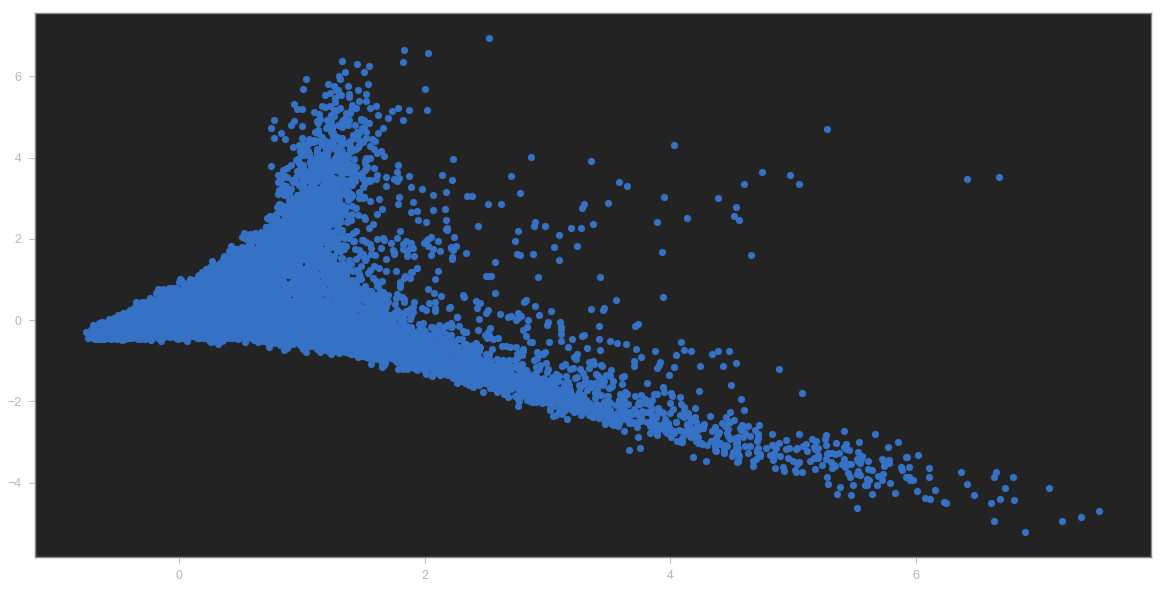

In [35]:
# Initialize PCA with n_components=2) so that we compress our vectors into plottable pairs
pca = PCA(n_components=2)
# Extract all the vectors in model
X = model.wv[model.wv.vocab]
# Fit PCA to our vectors
result = pca.fit_transform(X)
vocabulary = list(model.wv.vocab)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])

# for i, product in enumerate(vocabulary):
# 	pyplot.annotate(product, xy=(result[i, 0], result[i, 1]))
# pyplot.show();

This is a 2 dimensional representation of our product embedding vector space.

### User vectors

In [36]:
user_id = 1
products_for_user_id1 = sequence_dict[1][0] # The [0] is to access the list value 
print('Product sequence for user_id : \n {} \n'.format(products_for_user_id1))

product_vectors_user_id1 = model.wv[products_for_user_id1]
print('Vectors for products: \n{}\n'.format(product_vectors_user_id1))

# This is the vector for each one of the users
user_vector_id1 = np.average(product_vectors_user_id1, axis=0)
print('User vector: \n{}\n'.format(user_vector_id1))

Product sequence for user_id : 
 ['Soda' 'Organic String Cheese' '0% Greek Strained Yogurt'
 'XL Pick-A-Size Paper Towel Rolls' 'Milk Chocolate Almonds' 'Pistachios'
 'Cinnamon Toast Crunch' 'Aged White Cheddar Popcorn' 'Organic Whole Milk'
 'Organic Half & Half' 'Zero Calorie Cola'] 

Vectors for products: 
[[-2.6763628   0.31824473  0.65566254 ... -1.4784782   0.07485726
  -0.8639203 ]
 [-0.52891046 -0.13485053  0.06600048 ... -0.05863804  0.24986058
  -0.02632613]
 [-1.9657121   0.01630028  0.94796824 ... -0.942737    0.43372226
  -0.50444937]
 ...
 [-0.67903036  0.95805866  0.1831865  ...  0.6979856  -0.02034644
   0.81288105]
 [-1.0499882   0.3664749  -0.15180841 ...  0.19070117 -0.33798316
   0.1659437 ]
 [-1.7002043  -0.02417015  0.6590633  ... -0.8334774   0.42510745
  -0.4959854 ]]

User vector: 
[-1.24168992e+00  1.36013493e-01  4.64763433e-01 -1.69278800e-01
  1.03148746e+00  6.26158714e-02  9.46096145e-03 -5.48730612e-01
  3.29261810e-01  3.33291978e-01 -5.35542250e-01  3.2

In [37]:
# assert product_vectors[0].all(model.wv[sequence_dict[1][0][0]]) == True
# ## Vector for 'Soda
# print(model.wv['Soda'])
# # First vector in returned represenation
# print(product_vectors[0])
# # Vector representaion for the first item in the 
# print(model.wv[sequence_dict[1][0][0]])

In [38]:
def compute_user_vectors(model, user_ids, sequence_dict):
    user_vectors_dict = {}
    for user_id in user_ids:
        products_for_user = sequence_dict[user_id][0] # The [0] is to access the list value 
        product_vectors_user = model.wv[products_for_user]
        user_vectors_dict[user_id] = np.average(product_vectors_user, axis=0)
    return user_vectors_dict

In [39]:
usr_id_vector_dict = compute_user_vectors(model, user_ids_train, sequence_dict)

NameError: name 'user_ids_train' is not defined

In [ ]:
# assert usr_id_vector_dict[1] == user_vector_id1
print(usr_id_vector_dict[1])

In [ ]:
# usr_id_vector_dict.values()
usr_ids = list(usr_id_vector_dict.keys())
usr_vectors = list(usr_id_vector_dict.values())

In [ ]:
print('Numer of user_ids: {}'.format(len(usr_ids)))
print(usr_ids[0])
print()

In [ ]:
def get_similar_users(user_id, usr_id_vector_dict):
    user_vector = usr_id_vector_dict[user_id]
    
    for userid, user_vector in usr_id_vector_dict.items(): 
    

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(usr_vectors)
pyplot.scatter(result[:, 0], result[:, 1])

for i, user_id in enumerate(usr_ids):
	pyplot.annotate(usr_ids, xy=(result[i, 0], result[i, 1]))
pyplot.show();

In [ ]:
result